In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
from Bio.KEGG import Enzyme
import matplotlib
import io
import time
import pickle
import re
from rich.progress import Progress
from rdkit import Chem
from collections import Counter
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdFMCS
import pubchempy as pcp
from bs4 import BeautifulSoup
from urllib.parse import quote
import json

import math
import os

In [4]:
inchi_ligands = pd.read_pickle("parity_calcs/all_chem_descriptors_inchi_unique_pairs.pkl")

#inchi_ligands.index = inchi_ligands.ligand_entity_id
#inchi_ligands.head(1000).to_csv("pdb_ligands_inchi_1k.csv")

In [19]:
inchi_ligands.loc[inchi_ligands.pdb_entry_id == "6hp0"]

,pdb_entry_id,ligand_entity_id,descriptor,descriptor_type,protein_polymer_EC
1287917,6hp0,6hp0_9,"InChI=1S/C6H14O4/c7-1-3-9-5-6-10-4-2-8/h7-8H,1...",InChI,3.2.1.18
1287923,6hp0,6hp0_8,"InChI=1S/C2H6O2/c3-1-2-4/h3-4H,1-2H2",InChI,3.2.1.18
1287933,6hp0,6hp0_7,InChI=1S/C8H15NO6/c1-3(11)9-5-7(13)6(12)4(2-10...,InChI,3.2.1.18
1287940,6hp0,6hp0_6,InChI=1S/C17H26N4O5/c1-4-13(5-2)26-15-7-11(17(...,InChI,3.2.1.18
1287942,6hp0,6hp0_5,InChI=1S/Ca/q+2,InChI,3.2.1.18
1287948,6hp0,6hp0_4,InChI=1S/C6H12O5/c1-2-3(7)4(8)5(9)6(10)11-2/h2...,InChI,3.2.1.18
1287973,6hp0,6hp0_3,InChI=1S/C6H12O5/c1-2-3(7)4(8)5(9)6(10)11-2/h2...,InChI,3.2.1.18
1287987,6hp0,6hp0_2,InChI=1S/C6H12O5/c1-2-3(7)4(8)5(9)6(10)11-2/h2...,InChI,3.2.1.18


In [5]:
inchi_ligands.descriptor.nunique()

25542

In [6]:
print(f"""
Chains domains contains all of the chains and their associated cath/scop/pfam domains in which EC number for the entity was not null: {chains_domains.pdb.nunique()}
These map to {chains_domains.EC_descriptor.nunique()} EC numbers in PDBe-graph. This may contain partial EC numbers. 
When these are expanded to include all sub EC numbers, the total number of EC numbers searched is {chains_domains.filled_EC_descriptor.nunique()}
""")

NameError: name 'chains_domains' is not defined

In [7]:
chains_domains_chem_descriptors = pd.read_pickle("parity_calcs/all_chem_descriptors_inchi_unique_pairs.pkl")

print(f"""
We have a total of {chains_domains_chem_descriptors.ligand_entity_id.nunique()} ligands in this file.
and {chains_domains_chem_descriptors.protein_polymer_EC.str.split(",").explode().nunique()} EC numbers are associated with these.
""")


We have a total of 213957 ligands in this file.
and 3521 EC numbers are associated with these.



In [14]:
chains_domains_chem_descriptors.loc[chains_domains_chem_descriptors.pdb_entry_id == "6hzx"]

,pdb_entry_id,ligand_entity_id,descriptor,descriptor_type,protein_polymer_EC
489393,6hzx,6hzx_9,"InChI=1S/C3H8O3/c4-1-3(6)2-5/h3-6H,1-2H2",InChI,4.2.1.1
489403,6hzx,6hzx_8,InChI=1S/C12H10N2O3/c13-10-3-1-2-9-7(5-11(16)1...,InChI,4.2.1.1
489404,6hzx,6hzx_7,InChI=1S/C10H8N2O3/c11-6-3-1-2-5-8(13)4-7(10(1...,InChI,4.2.1.1
489415,6hzx,6hzx_6,InChI=1S/C12H10N2O5/c13-7-3-1-2-6-9(19-5-10(15...,InChI,4.2.1.1
489419,6hzx,6hzx_5,InChI=1S/C7H8N2O2/c8-4-5-2-1-3-6(9-5)7(10)11/h...,InChI,4.2.1.1
489427,6hzx,6hzx_4,InChI=1S/C13H15N3O3/c14-5-2-6-19-11-7-10(13(17...,InChI,4.2.1.1
489433,6hzx,6hzx_3,"InChI=1S/C19H23N3O5S/c20-28(25,26)18-8-6-16(7-...",InChI,4.2.1.1
489435,6hzx,6hzx_2,InChI=1S/Zn/q+2,InChI,4.2.1.1


In [8]:
parity_calcs = pd.read_pickle("parity_calcs/parity_calcs/all_parity_calcs.pkl")
parity_calcs["pdb"] = parity_calcs['pdb_ligand'].str[:4]
chains_domains_parity_calcs = parity_calcs.loc[parity_calcs.pdb_ligand.isin(chains_domains_chem_descriptors.ligand_entity_id.unique())]

In [15]:
parity_calcs.loc[parity_calcs.pdb == "6hzx"].pdb.unique()

array(['6hzx'], dtype=object)

In [212]:
unique_chains_domains_pdbs = pd.DataFrame({"pdb_id" : chains_domains_parity_calcs.pdb.unique()})

#unique_chains_domains_pdbs.to_csv("unique_chains_domains_pdbs.csv", index = False, header = None)

pdbline = unique_chains_domains_pdbs["pdb_id"].str.upper().tolist()
pdbline = ",".join(pdbline)

with open("unique_chains_domains_pdbs.txt", "w") as file:
    file.write(pdbline)

In [16]:
chains_domains_parity_calcs.loc[(chains_domains_parity_calcs.error.isna()) & (chains_domains_parity_calcs.error.str.startswith("Parity error: index 0 is out of bounds for axi") == False) & (chains_domains_parity_calcs.error != "No KEGG Compounds found for EC") & (chains_domains_parity_calcs.pdb == "6hzx")]

,pdb_ligand,compound,score,error,cancelled,pdb


In [17]:
chains_domains_parity_calcs.loc[chains_domains_parity_calcs.pdb == "6hzx"]

,pdb_ligand,compound,score,error,cancelled,pdb
19020,6hzx_9,KEGG_C01353,0.250000,None,False,6hzx
19021,6hzx_9,KEGG_C00011,0.285714,None,False,6hzx
19022,6hzx_9,KEGG_C00001,0.166667,None,False,6hzx
19023,6hzx_9,KEGG_C01353,0.250000,None,False,6hzx
19024,6hzx_9,KEGG_C00011,0.285714,None,False,6hzx
19025,6hzx_9,KEGG_C00001,0.166667,None,False,6hzx
19026,6hzx_8,KEGG_C01353,0.050000,None,False,6hzx
19027,6hzx_8,KEGG_C00011,0.052632,None,False,6hzx
19028,6hzx_8,KEGG_C00001,0.058824,None,False,6hzx
19029,6hzx_8,KEGG_C01353,0.050000,None,False,6hzx


In [214]:
ligands_with_score = chains_domains_parity_calcs.loc[(chains_domains_parity_calcs.compound.isna() == False)]
ligands_missing_score = chains_domains_parity_calcs.loc[(chains_domains_parity_calcs.compound.isna()) & (chains_domains_parity_calcs.pdb_ligand.isin(ligands_with_score.pdb_ligand.unique()) == False)]

In [215]:
chains_domains_parity_calcs.loc[chains_domains_parity_calcs.error == "No KEGG Compounds found for EC"]

,pdb_ligand,compound,score,error,cancelled,pdb
658,6yza_5,None,0.0,No KEGG Compounds found for EC,None,6yza
659,6yza_4,None,0.0,No KEGG Compounds found for EC,None,6yza
660,6yza_3,None,0.0,No KEGG Compounds found for EC,None,6yza
661,6yza_2,None,0.0,No KEGG Compounds found for EC,None,6yza
861,3nps_6,None,0.0,No KEGG Compounds found for EC,None,3nps
...,...,...,...,...,...,...
52668,4hn2_2,None,0.0,No KEGG Compounds found for EC,None,4hn2
52753,4rsl_3,None,0.0,No KEGG Compounds found for EC,None,4rsl
52754,4rsl_2,None,0.0,No KEGG Compounds found for EC,None,4rsl
52817,5he5_3,None,0.0,No KEGG Compounds found for EC,None,5he5


In [250]:
ligands_with_score

,pdb_ligand,compound,score,error,cancelled,pdb
0,1b42_3,KEGG_C00002,0.135135,None,False,1b42
1,1b42_3,KEGG_C00046,0.062500,None,False,1b42
2,1b42_3,KEGG_C00013,0.000000,None,False,1b42
3,1b42_3,KEGG_C00046,0.062500,None,False,1b42
4,1b42_3,KEGG_C00002,0.135135,None,False,1b42
...,...,...,...,...,...,...
52812,5h1y_3,KEGG_C00009,0.000000,None,False,5h1y
52813,5h1y_2,KEGG_C00002,0.125000,None,False,5h1y
52814,5h1y_2,KEGG_C00001,0.200000,None,False,5h1y
52815,5h1y_2,KEGG_C00008,0.142857,None,False,5h1y


In [218]:
ligands_with_score.reset_index().pdb_ligand.value_counts()

pdb_ligand
4u0p_4    51648
4u0o_2    51648
5exk_9    51648
5exk_8    51648
4u0p_3    51648
          ...  
1tb6_4        1
1tb6_5        1
1tb6_6        1
1tb6_7        1
8a3q_4        1
Name: count, Length: 171414, dtype: int64

In [220]:
ligands_with_score.pdb_ligand.nunique() + ligands_missing_score.pdb_ligand.nunique()
ligands_max_score = ligands_with_score.reset_index(drop = True).iloc[ligands_with_score.reset_index(drop = True).groupby("pdb_ligand")["score"].idxmax()]

213957

42543

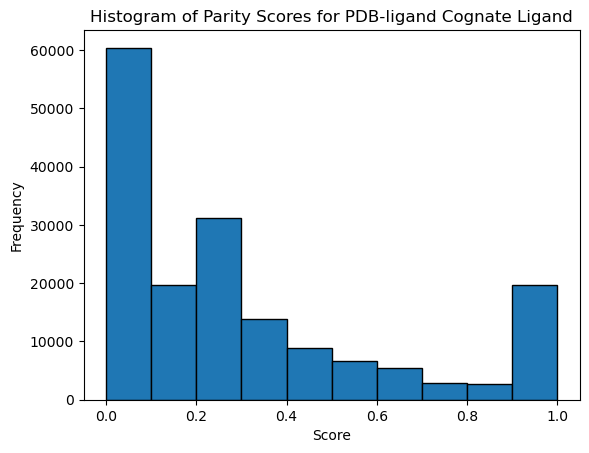

In [227]:
max_scores = ligands_with_score.loc[ligands_with_score.compound.isin(ner_compounds) == False].groupby('pdb_ligand')['score'].max()

plt.hist(max_scores, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of Parity Scores for PDB-ligand Cognate Ligand')
plt.show()

In [225]:
final_kegg_compound_reaction_enzyme_df = pd.read_pickle("kegg_information/final_kegg_compound_reaction_enzyme_df.pkl")

In [240]:
ner_compounds = final_kegg_compound_reaction_enzyme_df.loc[final_kegg_compound_reaction_enzyme_df.search_type == "NER"].unique_id.values.tolist()
entities_compounds = final_kegg_compound_reaction_enzyme_df.loc[final_kegg_compound_reaction_enzyme_df.search_type == "entities"].unique_id.values.tolist()

In [242]:
ligands_with_score.groupby('pdb_ligand')['score'].max() 
#ligands_with_score.loc[(ligands_with_score.compound.isin(entities_compounds))].score.mean()

pdb_ligand
107l_2    0.000000
107l_3    0.187500
108l_2    0.000000
108l_3    0.187500
109l_2    0.000000
            ...   
9rub_4    1.000000
9xia_2    0.692308
9xia_3    0.000000
9xim_2    1.000000
9xim_3    0.000000
Name: score, Length: 171414, dtype: float64

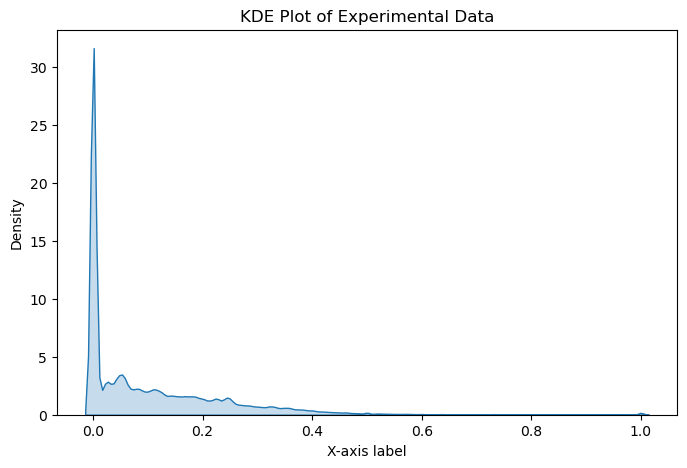

In [243]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.kdeplot(ligands_with_score["score"], fill=True)
plt.xlabel('X-axis label')
plt.ylabel('Density')
plt.title('KDE Plot of Experimental Data')
plt.show()

In [244]:
print(f"""
{round((len(max_scores.loc[max_scores > 0.55])/ len(max_scores)) * 100, 2)} % of pdb ligands have a cognate ligand match >0.55 PARITY score
""")


19.6 % of pdb ligands have a cognate ligand match >0.55 PARITY score



In [31]:
ligands_missing_score.iloc[0]["error"]

'No KEGG Compounds found for EC'

In [32]:
chains_domains.loc[(chains_domains.pdb.isin(ligands_missing_score.pdb.unique()))].filled_EC_descriptor.nunique()

7553

In [165]:
chains_domains.loc[(chains_domains.pdb.isin(ligands_with_score.pdb.unique()))].filled_EC_descriptor.nunique()

6816

In [ ]:
chains_domains_parity_calcs.loc[(chains_domains_parity_calcs.kegg_ligand.isna() == False) & (chains_domains_parity_calcs.kegg_ligand.str.startswith("G")) & (chains_domains_parity_calcs.score > 0.4)]

In [267]:
compound_list = get_enzyme_ligands("3.4.23.46", kegg_reaction_df, kegg_enzyme_df)
scores_list = parity_score_inchi("5he5_2", "InChI=1S/C4H6O6/c5-1(3(7)8)2(6)4(9)10/h1-2,5-6H,(H,7,8)(H,9,10)/t1-,2-/m1/s1", compound_list, kegg_compounds_df, timeout = 30)

We performed parity calcs between pairs of pdb ligands and potential cognate ligands (in the parity calcs file). 

In [61]:
print(f"""A total of {parity_calcs.pdb_ligand.nunique()} pdb ligands were tested, against a total of {parity_calcs.kegg_ligand.nunique()} kegg ligands""")

AttributeError: 'DataFrame' object has no attribute 'kegg_ligand'

domain_owner
uniquely_binding_domain    147917
partner_binding_domain      56317
minor_binding_domain        40271
dominant_binding_domain     33380
Name: count, dtype: int64

,pdb_id,cath_domain,ligand_entity_id,bound_ligand_id,bound_ligand_name,domain_counts,domain_owner
1537147,10gs,10gsA02,10gs_2,10gs_2_C_1,VWW,4,minor_binding_domain
1537155,10gs,10gsA01,10gs_2,10gs_2_C_1,VWW,76,dominant_binding_domain
1537143,10gs,10gsB02,10gs_2,10gs_2_E_1,VWW,4,minor_binding_domain
1537151,10gs,10gsB01,10gs_2,10gs_2_E_1,VWW,77,dominant_binding_domain
3599153,11ba,11baA00,11ba_3,11ba_3_D_1,UPA,68,dominant_binding_domain
...,...,...,...,...,...,...,...
3730290,9nse,9nseB01,9nse_8,9nse_8_R_1,GOL,3,partner_binding_domain
3730024,9nse,9nseB03,9nse_8,9nse_8_R_1,GOL,4,partner_binding_domain
2169372,9rub,9rubB01,9rub_2,9rub_2_C_1,RUB,4,minor_binding_domain
2169371,9rub,9rubA02,9rub_2,9rub_2_C_1,RUB,17,dominant_binding_domain


Do certain domains only exist as "partner domains"? 

So what about if we use surfaces to calculate the interactions between ligands in the PDB? This can give use an understanding of favourable and unfavourable interactions.

In [202]:
kegg_compounds = pd.read_pickle("kegg_information/final_kegg_compound_reaction_enzyme_df.pkl")

In [207]:
kegg_compounds.loc[kegg_compounds.search_type != "NER"].compound_id.nunique()

6142

In [245]:
sifts_pdb_ec = pd.read_csv("sifts_pdb_chain_enzyme.tsv", sep = "\t", comment = "#")
sifts_pdb_ec.groupby(['PDB', 'EC_NUMBER']).size()

len(sifts_pdb_ec.groupby(['PDB', 'EC_NUMBER']).size().reset_index())
sifts_pdb_ec.PDB.nunique()
inchi_ligands.pdb_entry_id.nunique()
ec_nums_exploded = ec_nums["(e.EC)"].str.split(",").explode().drop_duplicates()
len(ec_nums_exploded)
ec_nums_exploded.loc[ec_nums_exploded.isin(sifts_pdb_ec.EC_NUMBER.unique()) == False]

#what are uniprot groups and how can we use these to our advantage?

FileNotFoundError: [Errno 2] No such file or directory: 'sifts_pdb_chain_enzyme.tsv'